# Data Generation Demo

Demonstrating how to generate a dataset using this codebase.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog

In [37]:
best_agent = PIDAgent()

best_params = {'steps_u':10, 'scaling_factor':0, 'window_distance':1000} # window distance 1000 to turn off safety leash

In [38]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]]) # you will need to define a circle trajectory the same way

In [39]:
def run_trajectory(env_selector, wind_ranges, agent, params, speed, trajectory):
    env = env_selector.get_env("sliding", params, wind_ranges, trajectory, start_alt=30, has_turbulence=True)
    
    env.base_env.vehicle.mass = np.random.normal(10.33, 0.75) # randomly sample a mass - this seems like a reasonable distribution
    env.base_env.ctrl.ctrl_p.max_velocity = speed
    
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    motor_speeds = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        motor_speeds.append(log.vehicle.speeds)

    log.done_logging()
    return log, info, motor_speeds

`wind_ranges` will sample wind in a certain range:
- ex: [(0,5),(0,5),(0,0)] will sample 0-5 m/s in x, 0-5m/s in y, and 0 in z

If you want to fix the wind, you will need to pass something like  [(5,5),(0,0),(0,0)] for 5 m/s east wind or  [(0,0),(-5,-5),(0,0)] for 5 m/s south wind. The function below should be appropriate.

In [40]:
def sample_wind_range(magnitude):
    random_angle_degrees = np.random.uniform(0, 360)

    # Step 2: Convert the angle to radians
    random_angle_radians = np.deg2rad(random_angle_degrees)
    
    # Step 3: Calculate the components of the unit vector
    x_component = np.cos(random_angle_radians)
    y_component = np.sin(random_angle_radians)
    
    # Step 4: Create the unit vector
    unit_vector = np.array([x_component, y_component]) 
    wind_vector = unit_vector * magnitude

    wind_range = [(wind_vector[0], wind_vector[0]), (wind_vector[1], wind_vector[1]), (0,0)]
    return wind_range, wind_vector

In [41]:
sample_wind_range(3)

[(-2.325358766366235, -2.325358766366235),
 (-1.8954436440273565, -1.8954436440273565),
 (0, 0)]

In [44]:
wind_range, wind_vector = sample_wind_range(3)
log, info, motor_speeds = run_trajectory(env_selector, wind_range, best_agent, best_params, 15, square_wpts)

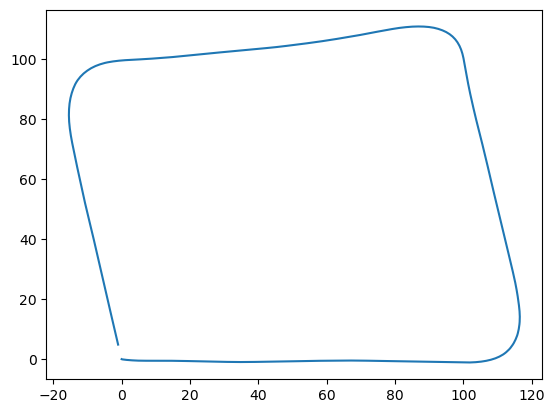

In [45]:
plt.plot(log.x, log.y) # this log should contain all the info you need for a flight

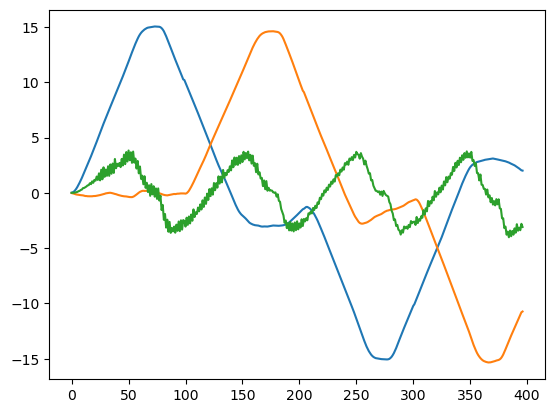

In [46]:
plt.plot(log.velocity)

In [52]:
plt.plot(motor_speeds)

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [48]:
info

{'u': array([ 0.,  0., 30.,  0.,  0.,  0.], dtype=float32),
 'dxdt': array([ 2.1330e+00, -1.1138e+01,  1.0600e-01, -9.3800e-01,  2.3340e+00,
        -9.5190e+00, -4.0000e-03, -2.3000e-02, -3.1000e-02, -0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=float32),
 'reached': True,
 'outofbounds': False,
 'outoftime': False,
 'tipped': False,
 'crashed': False}

In [50]:
if not info['reached']:
    print('Mission Failed')
else:
    print('Mission Success')

Mission Success
